# House Prices - EDA and models comparison

*Autores: David Tejero Ruiz & Miguel Gil Castilla*

El [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) ha sido obtenido de la página web de Kaggle en el apartado de competiciones. Este ha sido escogido debido a que está recomendado como un dataset de "juguete" con el que continuar el aprendizaje en python y ciencia del dato a un nivel más o menos básico. Nuestra idea es realizar un exploratory data análisis aplicando técnicas vistas en clase y ampliando estas con algunas ideas captadas de la red, tras esto trataremos nuestro dataset ya modificado para crear un modelo de regresión con el que predecir la variable respuesta *PriceSale*.

Una particularidad de este dataset es su elevado número de atributos (79), lo que lo hace muy adecuado para poner en práctica algunas técnicas vistas de ingeniería de características. Así, podemos extraer información relevante de ellas para realizar una predicción más o menos precisa del precio de venta de las diferentes viviendas.


Dado que en el conjunto test.csv no se proporciona el valor de la variable respuesta (era objetivo obtenerlo para la competición de Kaggle al que pertenece), nos hemos centrado en el conjunto *train.csv*, que hemos renombrado al archivo *data.csv* que se encuentra en este directorio, y será el conjunto de datos que analicemos.

In [1]:
import numpy as np

# Importamos el conjunto de datos
import pandas as pd
House_prices = pd.read_csv('data.csv')

# Para evitar avisos innecesarios (FutureWarnings):
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

Notar que Pandas por defecto, trata los valores NA (Not Available) como NaN (Not a Number). Si se analiza la descripción de los datos, NA es un valor que pueden tomar algunos atributos categóricos (no todos), por lo que no se trata de un valor perdido como tal, sino que  indica que no se puede calcular el valor del atributo, porque la vivienda no dispone de el item que se está evaluando. Por ejemplo, en el caso del atributo de calidad de la piscina, NA indica que la vivienda no dispone de piscina, lo cuál es información relevante, y no un valor perdido que tendríamos que imputar.

Hemos analizado la descripción de los diferentes atributos categóricos y aquellos en los que un NA podría aportar información relevante, son:

- Alley

- BsmtQual

- BsmtCond

- BsmtExposure

- BsmtFinType1

- BsmtFinType2

- FireplaceQu

- GarageType

- GarageYrBlt

- GarageFinish

- GarageQual

- GarageCond

- PoolQC

- Fence

- MiscFeature


In [2]:
na_attributes = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'PoolQC', 'Fence', 'MiscFeature']

In [3]:
# Vemos la cabecera de los datos
House_prices.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Como vemos, el dataset está compuesto por 81 columnas, de las cuales 79 serán las características que usaremos en la predicción, y las dos restantes sol el id (que no aporta información), y la variable que queremos predecir (precio de venta de la casa).

Además notamos que existe una riqueza de características alta, encontrando tanto valores numéricos como categóricos, cosa que analizaremos a continuación en el análisis.

In [4]:
# Vamos a definir un problema de regresión sobre el precio de las casas, por lo que la variable 
# objetivo del dataset será 'SalePrice' (última columna de nuestro dataset como es habitual)
y_data = House_prices['SalePrice']

# Preprocesado de datos

### Análisis de missing values y non-available values

Como comentamos al inicio, el dataset contiene valores NA, y en algunos casos realmente podrían aportar información útil al decir que no se tiene el objeto que tratamos de evaluar en el atributo. Vamos a ver qué atributos contienen valores NA, y cuántos de estos valores NA contienen.

In [5]:
# Vamos a contar las apariciones de NaNs en nuestro dataset al completo
print("Hay ", House_prices.isnull().sum().sum(), " valores nulos")

Hay  6965  valores nulos


In [6]:
# Separamos el conjunto de datos en atributos con posibles valores NA y 
# atributos con posibles missing values
House_prices_na = House_prices[na_attributes]
House_prices_mv = House_prices.drop(na_attributes, axis=1)

##### Missing values

In [7]:
# Vemos cuales de los atributos en los que un NaN significa Missing Value 
# tienen realmente valores NaN
mv_counts = House_prices_mv.isnull().sum()
mv_counts = mv_counts[mv_counts > 0]
print("Atributos que contienen missing values: \n{}".format(mv_counts))
print("Hay ", len(mv_counts), " atributos que contienen missing values")


Atributos que contienen missing values: 
LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64
Hay  4  atributos que contienen missing values


In [8]:
mv_counts

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

In [9]:
# De entre aquellos en los que NA no es un valor posible del atributo,
# y las apariciones de NaN son datos pérdidos, vamos a ver cuáles son 
# numéricos y cuáles no
House_prices_mv_numerics = House_prices_mv[mv_counts.keys()].select_dtypes(include=[np.number])
House_prices_mv_categorics = House_prices_mv[mv_counts.keys()].select_dtypes(exclude=[np.number])
print("Atributos numericos que contienen missing values: \n{}".format(House_prices_mv_numerics.keys().to_list()))
print("Atributos categóricos que contienen missing values: \n{}".format(House_prices_mv_categorics.keys().to_list()))


Atributos numericos que contienen missing values: 
['LotFrontage', 'MasVnrArea']
Atributos categóricos que contienen missing values: 
['MasVnrType', 'Electrical']


In [10]:
# Los atributos numéricos que contienen missing values los vamos a rellenar con la media
# de los valores de la columna
House_prices_mv_numerics = House_prices_mv_numerics.fillna(House_prices_mv_numerics.mean())

# Los atributos categóricos que contienen missing values los vamos a rellenar con el valor
# más frecuente de la columna
House_prices_mv_categorics = House_prices_mv_categorics.fillna(House_prices_mv_categorics.mode().iloc[0])

# Unimos los dos conjuntos de datos
House_prices_mv_fixed = pd.concat([House_prices_mv_numerics, House_prices_mv_categorics], axis=1)

# Guardamos los datos tratados
for key in mv_counts.keys():
    House_prices[key] = House_prices_mv_fixed[key]

# Vamos a comprobar que ya no hay valores nulos en los atributos que hemos tratado
if (House_prices[mv_counts.keys()].isnull().sum().sum() == 0):
    print("No hay valores nulos en estos conjuntos")

No hay valores nulos en estos conjuntos


##### Non-Available values


Vamos a ver que atributos contienen valores NA entre los que NA aporta información relevante.

In [11]:
# Vemos cuales de los atributos en los que un NaN significa Missing Value 
# tienen realmente valoress NaN
na_counts = House_prices_na.isnull().sum()
na_counts = na_counts[na_counts > 0]
print("Atributos que contienen Non Available values: \n{}".format(na_counts))
print("Hay ", len(na_counts), " atributos que contienen Non Available values")

Atributos que contienen Non Available values: 
Alley           1369
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Hay  15  atributos que contienen Non Available values


In [12]:
House_prices_na_numerics = House_prices_na.select_dtypes(include=[np.number])
House_prices_na_categorics = House_prices_na.select_dtypes(exclude=[np.number])
print("Atributos numericos que contienen Non Available values: \n{}".format(House_prices_na_numerics.keys().to_list()))
print("Atributos categóricos que contienen Non Available values: \n{}".format(House_prices_na_categorics.keys().to_list()))

Atributos numericos que contienen Non Available values: 
['GarageYrBlt']
Atributos categóricos que contienen Non Available values: 
['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


Vamos a empezar tratando el caso especial del único atributo numérico que tiene un NA como valor informativo, hablamos del **GarageYrBlt**. Este atributo codifica el año en el que se construyó el garaje de la casa, y un valor NA indica que la casa no tiene garaje. La información de "no tenemos garaje" puede ser relevante, por lo que tenemos que tratar este caso cuidosamente.

Sin embargo, parte de los atributos que analizaremos un poco más adelante: GarageType, GarageFinish, GarageCond y Garageal, son atributos categóricos cuyo valor NA indica igualmente "no tenemos garaje", por lo que esa información en este atributo en particular es redundante.

Por tanto, hemos llegado a la decisión de sustituir los valores NA de GarageYrBlt por la media de los valores no NA de este atributo. De esta forma, cuando posteriormente le apliquemos una normalización estándar al atributo y le restemos la media, obtendremos un valor nulo, y por tanto no afectará a la predicción dado a que así indicaremos que no es relevante ese valor en este atributo.

In [13]:
House_prices_na_numerics = House_prices_na_numerics.fillna(House_prices_na_numerics.mean())

Para el resto de valores NA, los NaNs indican un posible valor categorico, por lo que vamos a sustituirlos por la cadena "None", para que se traten como un posible valor categórico más.

In [14]:
# Rellenamos los NaNs con la cadena 'None
House_prices_na_categorics = House_prices_na_categorics.fillna('None')

# Unimos los dos conjuntos de datos tratados
House_prices_na_fixed = pd.concat([House_prices_na_numerics, House_prices_na_categorics], axis=1)

# Guardamos los datos tratados
for key in na_counts.keys():
    House_prices[key] = House_prices_na_fixed[key]

In [15]:
# Vamos a comprobar que ya no hay valores nulos en nuestro conjunto de datos
if (House_prices.isnull().sum().sum() == 0):
    print("No hay valores nulos en estos conjuntos")

No hay valores nulos en estos conjuntos


### Fase inicial de ingeniería de características
Vamos a analizar estas sustituticiones con los valores 'None' que repercusión tiene sobre el conjunto de datos. Se mostrará una gráfica con la cantidad de estos valores para valorar si es necesario seguir con la exploración o simplemente eliminar las estancias.

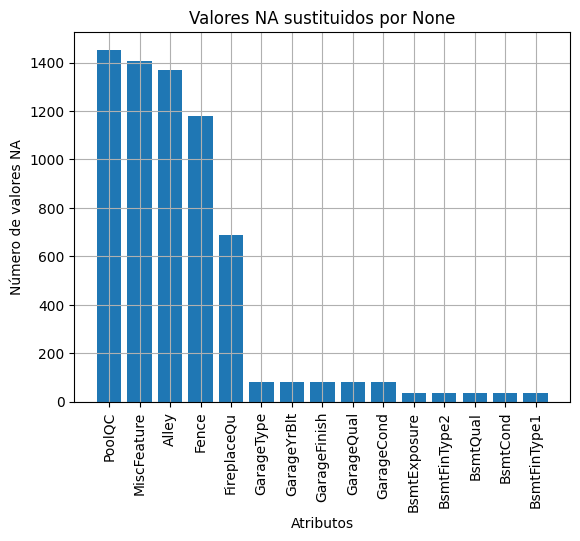

Los 4 mayores valores NA sustituidos por None son:
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
dtype: int64


In [16]:
# Vamos a graficar los valores NA que susituimos por 'None'
import matplotlib.pyplot as plt

ordenados_na = na_counts.sort_values(ascending=False)
plt.bar(ordenados_na.index, ordenados_na)
plt.xticks(rotation='vertical')
plt.ylabel('Número de valores NA')
plt.xlabel('Atributos')
plt.title('Valores NA sustituidos por None')
plt.grid()
plt.show()

# Print de los 4 mayores:
print("Los 4 mayores valores NA sustituidos por None son:")
print(ordenados_na.head(4))

Se observa que existe una cantidad exuberante de datos marcados con None, superando el 50% de las instancias, para 4 de los atributos, concretamente:
 - PoolQC: 1453
 - MiscFeature: 1406 
 - Alley: 1369
 - Fence: 1179
 
Debemos de considerar que el número total de instancias en el dataset es de **1460**.

Para ello dibujaremos el par atributo-variable respuesta para ver la relación entre estos dos, concretamente en los valores que no son None. Con esta comparación veremos si es relevante la información que nos aporta o no el atributo, decidiendo si eliminarlo o no..

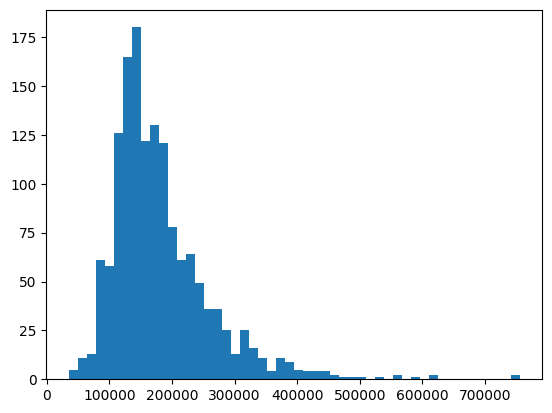

In [17]:
# Pintamos histograma de la variable objetivo, para ver su distribución
plt.hist(y_data, bins=50)
plt.show()

Esto nos da la intuición de dónde se sitúa la media de la variable respuesta y somo es su distribución, con ella podremos decidir si eliminar o no algunso atributos. Nuestra idea es que si los valores que no son 'None' son pocos y se sitúan cercanos a la donde de encuentran la mayoría de instancias (cercanos a la media de la variable respuesta), probablemente estos atributos no aportarán información relevante para la regresión, comparado con la información de otros atributos.

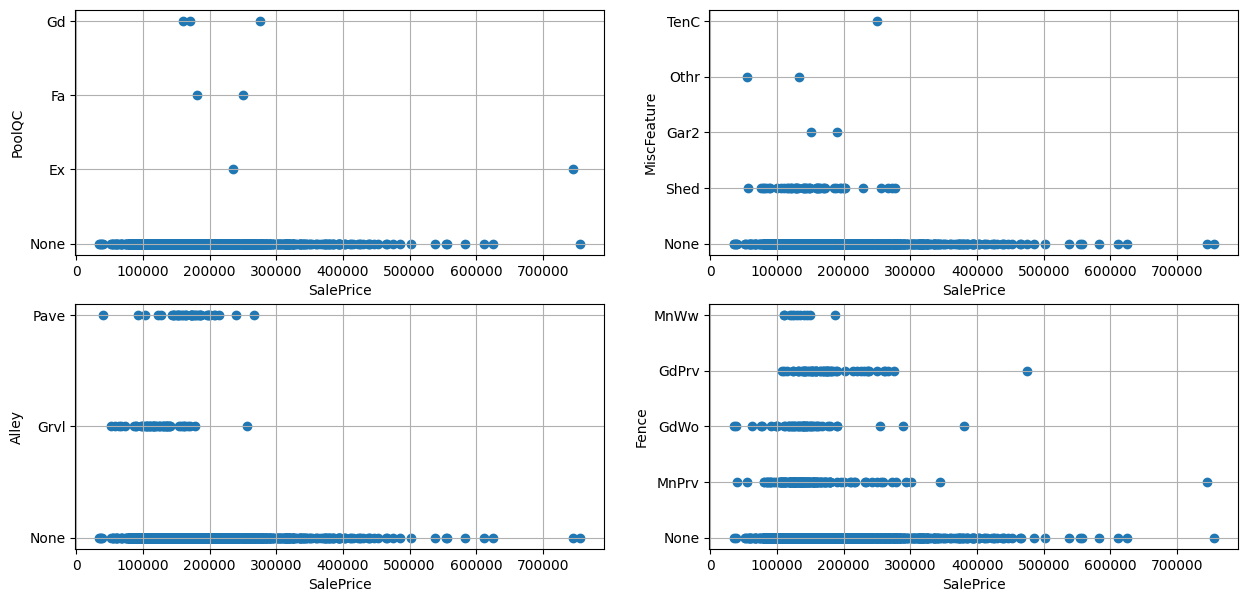

In [18]:
# Mostramos los valores  de las 4 variables con mayor número de valores NA
# en aquellos que son diferentes de None.

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax[0,0].scatter(House_prices['SalePrice'], House_prices[ordenados_na.index[0]])
ax[0,0].set_xlabel('SalePrice')
ax[0,0].set_ylabel(ordenados_na.index[0])
ax[0,0].grid()

ax[0,1].scatter(House_prices['SalePrice'], House_prices[ordenados_na.index[1]])
ax[0,1].set_xlabel('SalePrice')
ax[0,1].set_ylabel(ordenados_na.index[1])
ax[0,1].grid()

ax[1,0].scatter(House_prices['SalePrice'], House_prices[ordenados_na.index[2]])
ax[1,0].set_xlabel('SalePrice')
ax[1,0].set_ylabel(ordenados_na.index[2])
ax[1,0].grid()

ax[1,1].scatter(House_prices['SalePrice'], House_prices[ordenados_na.index[3]])
ax[1,1].set_xlabel('SalePrice')
ax[1,1].set_ylabel(ordenados_na.index[3])
ax[1,1].grid()

plt.show()

Como se puede observar en las gráficas comparativas, se observa que los atributos toman 'None' a lo largo de todo el rango de valores de SalePrice. Vemos que los valores que no son None de los atributos categóricos son pocos y se encuentran además en la zona donde tenemos un alto número de instancias, con lo cual, no aportan información relevante en este problema de regresión. Es por esto por lo que decidimos directamente eliminar estos atributos categóricos.

In [19]:
# Eliminamos los 4 atributos que más NA contienen 
House_prices = House_prices.drop(ordenados_na.head(4).index, axis=1)

### Construcción de nuestro dataset
Tras haber realizado un primer análisis inicial, vamos a construir el dataset de partida, que será el que usaremos para realizar el análisis exploratorio de datos y la construcción de los modelos de predicción.

In [20]:
# Definimos el dataset de datos de entrada (X_data) como el dataset sin la variable objetivo
# y sin la variable 'Id' (que no aporta información)
X_data = House_prices.drop(['SalePrice', 'Id'], axis=1)

# Para tratar los diferentes atributos lo primero es distinguir entre las variables cuantitativas 
# (numéricas) y cualitativas (categóricas)
# Ya que el tipo de dato 'object' engloba a las variables categóricas y a las variables de tipo
# # string, se puede usar dicho tipo de dato para distinguir las variables en numéricas y categóricas
numerical_atr = [col for col in X_data.columns if X_data.dtypes[col] != 'object']
categorical_atr = [col for col in X_data.columns if X_data.dtypes[col] == 'object']

print("Hay ", len(numerical_atr), " datos numéricos: ",numerical_atr)
print("Hay ", len(categorical_atr), " datos categóricos: ",categorical_atr)

Hay  36  datos numéricos:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Hay  39  datos categóricos:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garage

### Codificación de atributos categóricos

In [21]:
# Mostramos las variables categoricas
X_data[categorical_atr].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


Como bien sabemos, estos atributos categóricos debemos transformarlos a valores numéricos para poder trabajar con ellos. Existen diferentes técnicas para realizar esto, y para hacerlo de forma consistente, debemos analizar la naturaleza de los diferentes atributos categóricos.

Notamos que existen una serie de variables categóricas a cuyos atributos podemos asignarles un valor numérico según un orden. Estos casos son cuando hablamos de calidades (a mayor calidad vamos a asignar un valor superior) o cuando cuantificamos con palabras una cantidad (por ejemplo, el LandSlope caracteriza la pendiente del terreno, y podemos asignarle un valor numérico mayor a una mayor pendiente).

In [22]:
# Basándonos en el archivo data_description.txt codificamos las variables categóricas con información cuantitativa
X_data['LotShape'] = X_data['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
X_data['LandSlope'] = X_data['LandSlope'].map({'Gtl': 0, 'Mod': 1, 'Sev': 2})
X_data['ExterQual'] = X_data['ExterQual'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})
X_data['ExterCond'] = X_data['ExterCond'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})
X_data['BsmtQual'] = X_data['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
X_data['BsmtCond'] = X_data['BsmtCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
X_data['BsmtExposure'] = X_data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
X_data['BsmtFinType1'] = X_data['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
X_data['BsmtFinType2'] = X_data['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
X_data['HeatingQC'] = X_data['HeatingQC'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})
X_data['KitchenQual'] = X_data['KitchenQual'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})
X_data['Functional'] = X_data['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})
X_data['FireplaceQu'] = X_data['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
X_data['GarageFinish'] = X_data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0})
X_data['GarageQual'] = X_data['GarageQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
X_data['GarageCond'] = X_data['GarageCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
X_data['PavedDrive'] = X_data['PavedDrive'].map({'Y': 2, 'P': 1, 'N': 0})

In [23]:
# Estas dos características podemos tratarlas como binarias al tener solo dos posibles valores
X_data['CentralAir'] = X_data['CentralAir'].map({'Y': 1, 'N': 0})
X_data['Street'] = X_data['Street'].map({'Pave': 1, 'Grvl': 0})

Las que nos quedan, son variables categóricas que no podemos ordenar, y por tanto, debemos aplicar una codificación one-hot. Para ello, vamos a usar la función OneHotEncoder de sklearn, que nos permite realizar esta codificación de forma sencilla.

In [24]:
# Recalculamos los valores que siguen siendo categóricos
categorical_atr = [col for col in X_data.columns if X_data.dtypes[col] == 'object']
print("Quedan ", len(categorical_atr), " datos categóricos: ",categorical_atr)

Quedan  20  datos categóricos:  ['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']


In [25]:
from sklearn.preprocessing import OneHotEncoder

# Usamos OneHotEncoder para codificar las variables categóricas
encoder = OneHotEncoder(sparse=False)
X_data_encoded = pd.DataFrame(encoder.fit_transform(X_data[categorical_atr]))
X_data_encoded.columns = encoder.get_feature_names(categorical_atr)

# Borramos las variables categóricas originales y añadimos las nuevas codificadas
X_data = X_data.drop(categorical_atr ,axis=1)
X_data = pd.concat([X_data, X_data_encoded], axis=1)

# Mostramos los datos de entrada
X_data.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,3,0,7,5,2003,2003,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,1,3,0,6,8,1976,1976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,1,2,0,7,5,2001,2002,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,1,2,0,7,5,1915,1970,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,1,2,0,8,5,2000,2000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Mencionar aunque 214 parezcan muchos atributos, gracias al label encoding manual que hemos realizado arriba usando información de la descripción de los datos, nos hemos ahorrado hacer one-hot-encoding de todos los atributos categóricos, lo cual supondría obtener bastantes más atributos, aumentando consideralmente la complejidad del problema.

Notar que hemos optado por usar one-hot-encoding para las variables en las que no podemos definir un orden, y no otro tipo de codificaciones, para no introducir un orden artificial que no existiría en la realidad.

In [26]:
# Probamos que no hay valores nulos en el conjunto final de datos
if (X_data.isnull().sum().sum() == 0):
    print("No hay valores nulos en estos conjuntos")

# Probamos que no quedan variables categóricas
categorical_atr = [col for col in X_data.columns if X_data.dtypes[col] == 'object']
print("Quedan ", len(categorical_atr), " datos categóricos: ",categorical_atr)

No hay valores nulos en estos conjuntos
Quedan  0  datos categóricos:  []


### Ingeniería de características avanzada

##### Multicolinealidad

In [27]:
# Obtenermos la matriz de correlación de los datos de entrada
correlation_matrix = X_data.corr()

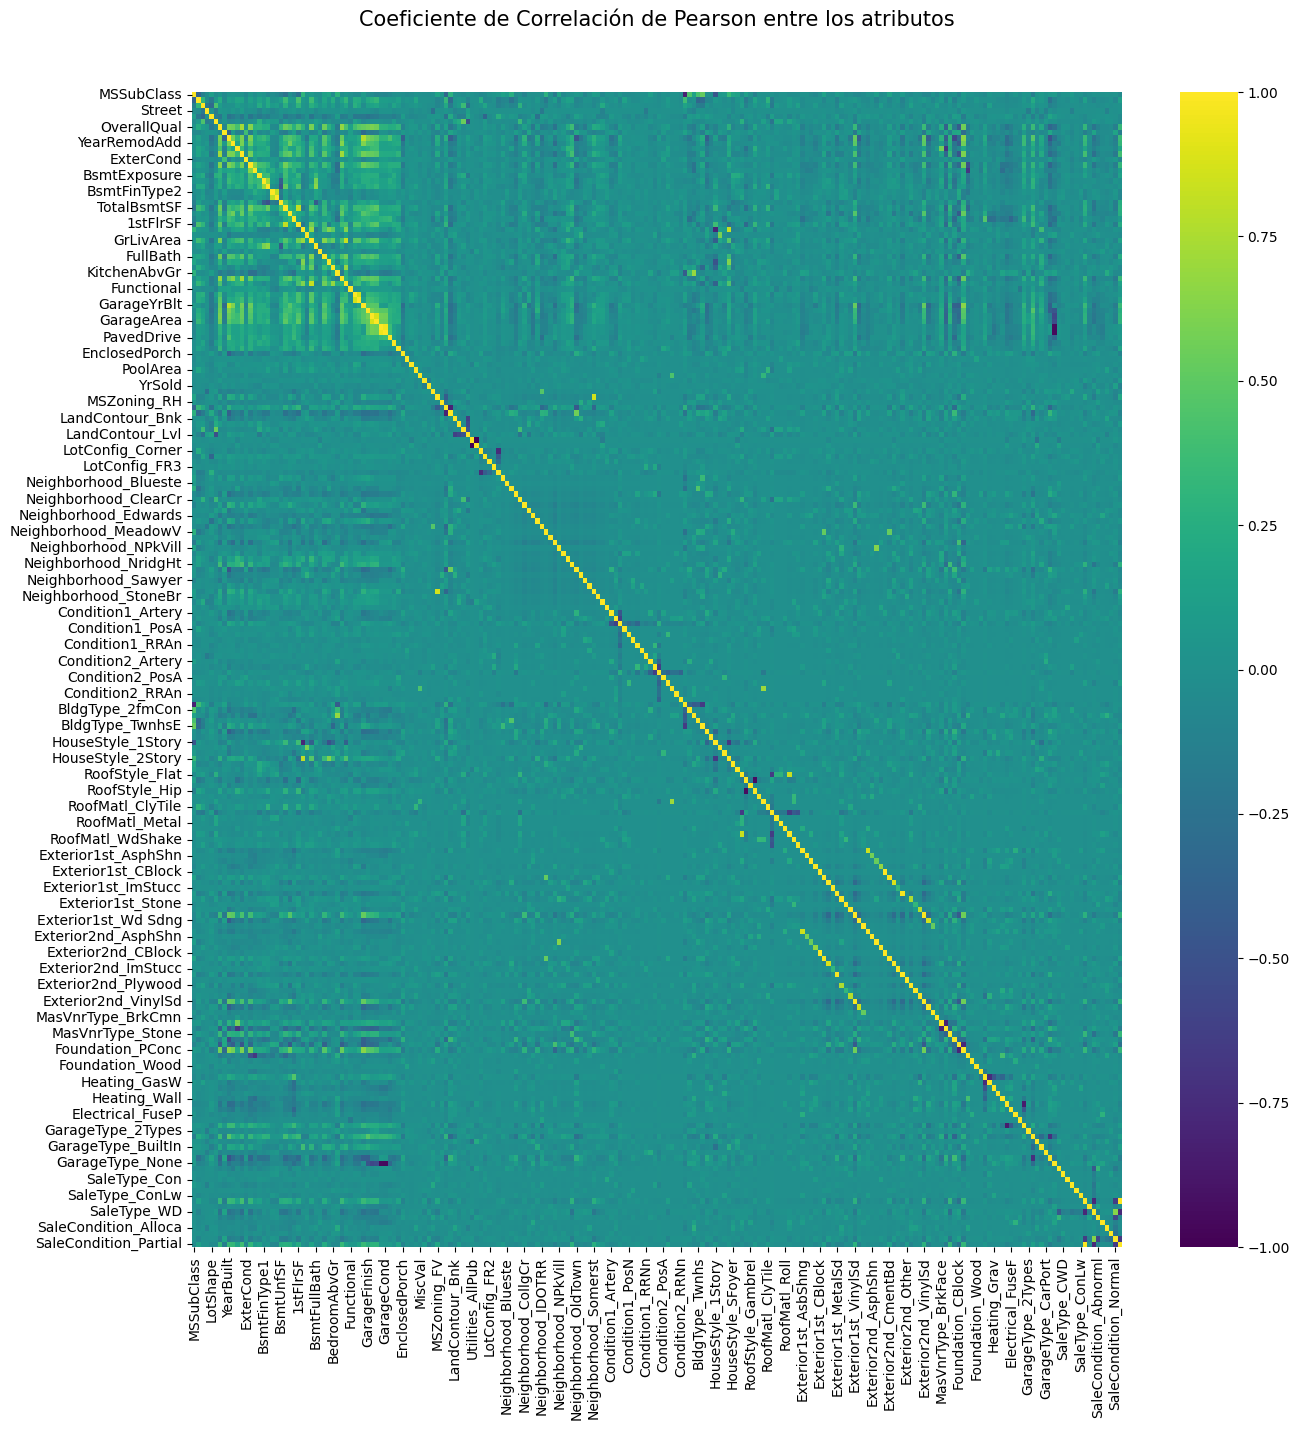

In [28]:
# Coeficiente de correlación de Pearson entre los atributos
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(correlation_matrix, cmap='viridis',vmax=1)
plt.show()

In [29]:
# Vamos a identificar pares de atributos con correlación mayor a 0.7
# y vamos a eliminar uno de los dos atributos de cada par
# para evitar la multicolinealidad

# Mantenemos una lista de atributos eliminados para no eliminarlos dos veces, y simplifcamos

# La matriz es simétrica, por lo que definimos los bucles para recorrer solo la mitad superior
# de la matriz

# Tenemos en cuenta tanto correlación positiva como negativa, por lo que usamos el valor absoluto

umbral = 0.7
atributos_eliminados = []
for i in range(len(correlation_matrix.columns)): 
    for j in range(i+1, len(correlation_matrix.columns)): 
        if (np.abs(correlation_matrix.iloc[i, j]) >= umbral):
            if (correlation_matrix.columns[j] not in atributos_eliminados):
                atributo = correlation_matrix.columns[j]
                atributos_eliminados.append(atributo)
                print("Eliminamos el atributo ", atributo, " por tener una correlación mayor a ", umbral, " con el atributo ", correlation_matrix.columns[i])

print("Se van a eliminar ", len(atributos_eliminados), " atributos")

Eliminamos el atributo  BldgType_1Fam  por tener una correlación mayor a  0.7  con el atributo  MSSubClass
Eliminamos el atributo  ExterQual  por tener una correlación mayor a  0.7  con el atributo  OverallQual
Eliminamos el atributo  GarageYrBlt  por tener una correlación mayor a  0.7  con el atributo  YearBuilt
Eliminamos el atributo  KitchenQual  por tener una correlación mayor a  0.7  con el atributo  ExterQual
Eliminamos el atributo  BsmtFinSF2  por tener una correlación mayor a  0.7  con el atributo  BsmtFinType2
Eliminamos el atributo  1stFlrSF  por tener una correlación mayor a  0.7  con el atributo  TotalBsmtSF
Eliminamos el atributo  HouseStyle_1Story  por tener una correlación mayor a  0.7  con el atributo  2ndFlrSF
Eliminamos el atributo  HouseStyle_2Story  por tener una correlación mayor a  0.7  con el atributo  2ndFlrSF
Eliminamos el atributo  TotRmsAbvGrd  por tener una correlación mayor a  0.7  con el atributo  GrLivArea
Eliminamos el atributo  FireplaceQu  por tener un

In [30]:
# Eliminamos los atributos de la lista de atributos a eliminar
X_data = X_data.drop(atributos_eliminados, axis=1) 

##### Metodos de filtrado para selección de características
A continuación, vamos a estudiar la correlación de los atributos con la variable respuesta, para ver si podemos eliminar algunos atributos que no aporten información relevante para la predicción.

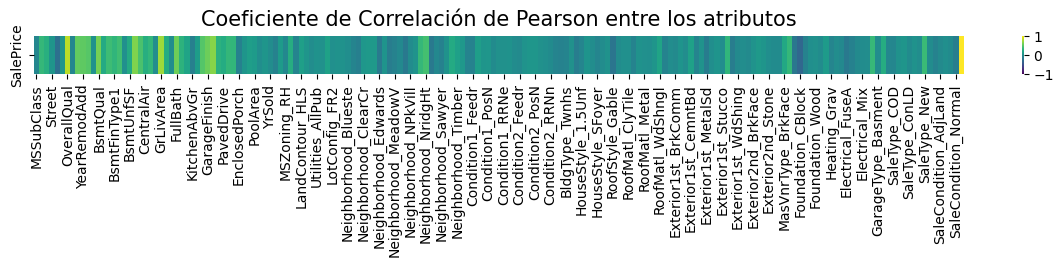

In [31]:
correlation_matrix = pd.DataFrame(pd.concat([X_data, y_data], axis=1)).corr()
correlation_matrix = correlation_matrix['SalePrice']

# Ploteamos la matriz de correlación de los datos de entrada
plt.figure(figsize=(15, 0.5))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(correlation_matrix.to_frame().T, cmap='viridis', vmax=1, vmin=-1)
plt.xticks(rotation=90)
plt.show()

In [32]:
# Vamos a eliminar los atributos que tengan una correlación pequeña con la variable objetivo
umbral = 0.025
atributos_a_eliminar = []
for i in range(len(correlation_matrix)):
    if (np.abs(correlation_matrix[i]) < umbral):
        atributo = correlation_matrix.index[i]
        atributos_a_eliminar.append(atributo)
        print("Eliminamos el atributo ", atributo, " por tener una correlación menor a ", umbral, " con la variable objetivo")

print("Se van a eliminar ", len(atributos_a_eliminar), " atributos")

Eliminamos el atributo  ExterCond  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  BsmtFinType2  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  BsmtHalfBath  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  MiscVal  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  Utilities_AllPub  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  LotConfig_Corner  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  LotConfig_FR2  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  LotConfig_FR3  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  Neighborhood_Blmngtn  por tener una correlación menor a  0.025  con la variable objetivo
Eliminamos el atributo  Neighborhood_Blueste 

In [33]:
# Eliminamos los atributos de la lista de atributos a eliminar
X_data = X_data.drop(atributos_a_eliminar, axis=1)

In [34]:
X_data.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_COD,SaleType_Con,SaleType_ConLD,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal
0,60,65.0,8450,1,3,0,7,5,2003,2003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20,80.0,9600,1,3,0,6,8,1976,1976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60,68.0,11250,1,2,0,7,5,2001,2002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,70,60.0,9550,1,2,0,7,5,1915,1970,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60,84.0,14260,1,2,0,8,5,2000,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Análisis de Outliers
Vamos a añadir un análisis de outliers, para ver si podemos eliminar algunas intancias que no aporten información relevante para la predicción.

\TODO explicar

In [35]:
outliers = {}
for key in X_data.keys():
    q1 = X_data[key].quantile(0.25)
    q3 = X_data[key].quantile(0.75)
    iqr = q3 - q1
    umbral_inferior = q1 - 1.5 * iqr
    umbral_superior = q3 + 1.5 * iqr
    outliers_encontrados = X_data[(X_data[key] < umbral_inferior) | (X_data[key] > umbral_superior)].index
    outliers[key] = outliers_encontrados

# Vamos a identificar los outliers que aparezcan en un minimo de atributos
# y vamos a eliminarlos
minimo_atributos_para_eliminar = 10
indices_outliers = []
contador_instancias = {}

# Contar el número de ocurrencias de cada instancia
for atributo, indices in outliers.items():
    for indice in indices:
        if indice not in contador_instancias:
            contador_instancias[indice] = 1
        else:
            contador_instancias[indice] += 1

# Identificar los índices de las instancias que son outliers en un número mínimo de atributos
for instancia, contador in contador_instancias.items():
    if contador >= minimo_atributos_para_eliminar:
        indices_outliers.append(instancia)

# Eliminamos los outlier
X_data = X_data.drop(indices_outliers, axis=0)
y_data = y_data.drop(indices_outliers, axis=0)

print("Se han eliminado ", len(indices_outliers), " instancias")

Se han eliminado  142  instancias


### División en entrenamiento, validación y prueba

In [36]:
# Dividimos el conjunto de datos en tres subconjuntos: entrenamiento, validación y test
# En una proprorción 50% - 20% - 30% respectivamente

train_size = 0.7
val_size = 0.2
test_size = 0.3

from sklearn.model_selection import train_test_split
# Realizamos esta división en train y test para hacer validación cruzada con un conjunto de entrenamiento que será dividido en folds y un conjunto de test 
# que será usado para evaluar el modelo final como datos nunca vistos
X_train, X_aux, y_train, y_aux = train_test_split(X_data, y_data, test_size=(1-train_size), random_state=41)
# Dividimos el conjunto auxiliar en validación y test
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=test_size/(test_size + val_size), random_state=41)

# Mostramos los tamaños de los conjuntos de datos
print("Tamaño del conjunto de entrenamiento: ", len(X_train))
print("Tamaño del conjunto de test: ", len(X_test))
print("Tamaño del conjunto de validación: ", len(X_val))

Tamaño del conjunto de entrenamiento:  922
Tamaño del conjunto de test:  238
Tamaño del conjunto de validación:  158


### Normalización de atributos

In [37]:
# Normalizamos las variables numéricas para que todas tengan media 0 y desviación típica 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X_data.columns)
X_test = pd.DataFrame(X_test, columns=X_data.columns)
X_val = pd.DataFrame(X_val, columns=X_data.columns)

# Mostramos los datos de entrada
X_train.head()

X_data = pd.concat([X_train, X_val, X_test])

# Modelos
Los modelos escogidos para realizar el entrenamiento y que más tarde pondremos a prueba serán:
- Regresión Lineal
- Random Forest
- Gradient Boosting

## Proceso de elección del modelo de regresión
Para escoger el modelo de regresión, vamos a realizar los siguientes pasos:
1. Dividimos los datos en **tres** conjuntos: entrenamiento, validación y test.
2. Escogemos un modelo de regresión entre los que hemos mencionado anteriormente.
3. Entrenamos dicho modelo con los datos de entrenamiento y realizamos un **ajuste de sus hiperparámetros** con los datos de validación.
4. Finalmente, para el conjunto con "mejores" hiperparámetros obtenidos, realizaremos **validación cruzada** uniendo los conjuntos de entrenamiento y validación, obteniendo una medida robusta de las métricas de rendimiento del modelo.
5. Repetimos estos pasos anteriores para cada uno de los modelos de regresión que queremos comparar.
6. Escogemos el modelo que mejores métricas tenga en la validación cruzada, lo entrenamos con todo el conjunto de datos de entrenamiento y validación, y lo **evaluamos en el conjunto de test**, que no hemos usado hasta ahora, para dar así una medida de rendimiento realista del modelo final.


## Métricas
Las métricas de evaluación del rendimiento del modelo que elegimos son las siguientes:

- Error absoluto medio (MAE): Esta métrica se define como el error medio, es decir, variable respuesta - valor predicho : $MAE = \frac{\sum|y-\hat y|}{N}$ (donde N es el número de instancias). Este nos da el error en la misma unidad que la variable respuesta, con lo cual es bastante intuitivo. En cambio, no es derivable con lo que habría que usar métodos como el descenso por el gradiente como optimizador para el entrenamiento del modelo. 

- Error cuadrático medio (MSE): Esta métrica se define como: $MSE = \frac{\sum(y-\hat y)²}{N}$. Este fue el que utilizamos en una primera instancia y confundió nuestro entendimiento de los resultados al tener valores tan elevados. Esto es debido a que evidentemente es por su valor cuadrático, aún así es interesante porque puede usarse como función de pérdida.

- La métrica R2: también llamada coeficiente de determinación, es una métrica que indica qué tan bien se ajusta un modelo de regresión a los datos observados, variando entre 0 y 1. Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 significa que el modelo no puede explicar la variabilidad de los datos. De hecho, un valor de cero, sería lo que obtendría un modelo que devuelva siempre el valor medio de los datos.


In [38]:
# Importamos todas las métricas que emplearemos para evaluar el rendimiento de los modelos
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Debido a que nuestra cantidad de datos no es muy grande, vamos a usar validación cruzada en lugar del método holdout para devolver una medida de rendimiento final:


In [68]:

# Dividimos el conjunto de entrenamiento en 5 subconjuntos
from sklearn.model_selection import KFold

# Creamos una función para hacer la validación cruzada
def cross_validation(model, X, y, n_splits=10):

    # Aplicamos  shuffle para que los datos se mezclen antes de dividirlos
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    splits = kf.split(X)
    
    scores_mae = []
    scores_mse = []
    scores_r2 = []


    for train_idx, val_idx in splits:
        # Extraemos el conjunto de entrenamiento y el conjunto de validación indexando
        # con los índices de cada conjunto aportados por la función .split()
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Entrenamos el modelo
        model.fit(X_train, y_train)
        
        # Evaluamos el modelo
        y_pred = model.predict(X_val)
        
        scores_mae.append(mean_absolute_error(y_pred, y_val))
        scores_mse.append(mean_squared_error(y_pred, y_val))
        scores_r2.append(r2_score(y_pred, y_val))
   
    return np.mean(scores_mse), np.mean(scores_mae), np.mean(scores_r2)

## Regresión Lineal

En primer lugar comenzaremos con un modelo lo más simple posible para casos de regresión, el modelo visto en clase *Regresión Lineal*, así tendremos una base con la que comparar modelos más complejos a posteriori. Con esto conseguiremos algo así como un modelo *"Dummy"*.

In [45]:
## Cargamos el modelo de regresión lineal
from sklearn.linear_model import LinearRegression

# Creamos el modelo, entrenamos con el conjunto de entrenamiento 
# y validamos con el conjunto de validación
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_val = reg.predict(X_val)

# Calculamos las métricas de rendimiento
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)

# Mostramos las métricas de rendimiento
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)

MAE:  53090726970832.17
MSE:  4.453427955970387e+29
RMSE:  667340089906967.0
R2:  -7.2372883185176855e+19


Como vemos los resultados obtenidos no son nada buenos, obteniendo unos errores medios enormes, y un R2 muy negativo, vamos a analizar un poco qué es lo que está pasando. Lo primero de todo, vamos a ver que métricas obtiene el modelo de regresión lineal sobre el conjunto de entrenamiento, para ver si el modelo está sobreajustando o no.

In [46]:
# Metricas sobre el conjunto de entrenamiento
y_pred_train = reg.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

# Mostramos las métricas de rendimiento
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)

MAE:  14150.113702557806
MSE:  406333215.381752
RMSE:  20157.70858460237
R2:  0.9218264676255818


Vemos que las métricas sobre el conjunto de train son mucho mejores, pasando , lo que nos indica que el modelo está posiblemente sobreajustado y no estamos generalizando bien. Para confirmar esto, vamos a ver qué valores predice el modelo sobre ambos conjuntos, y vamos a compararlos con los valores reales.

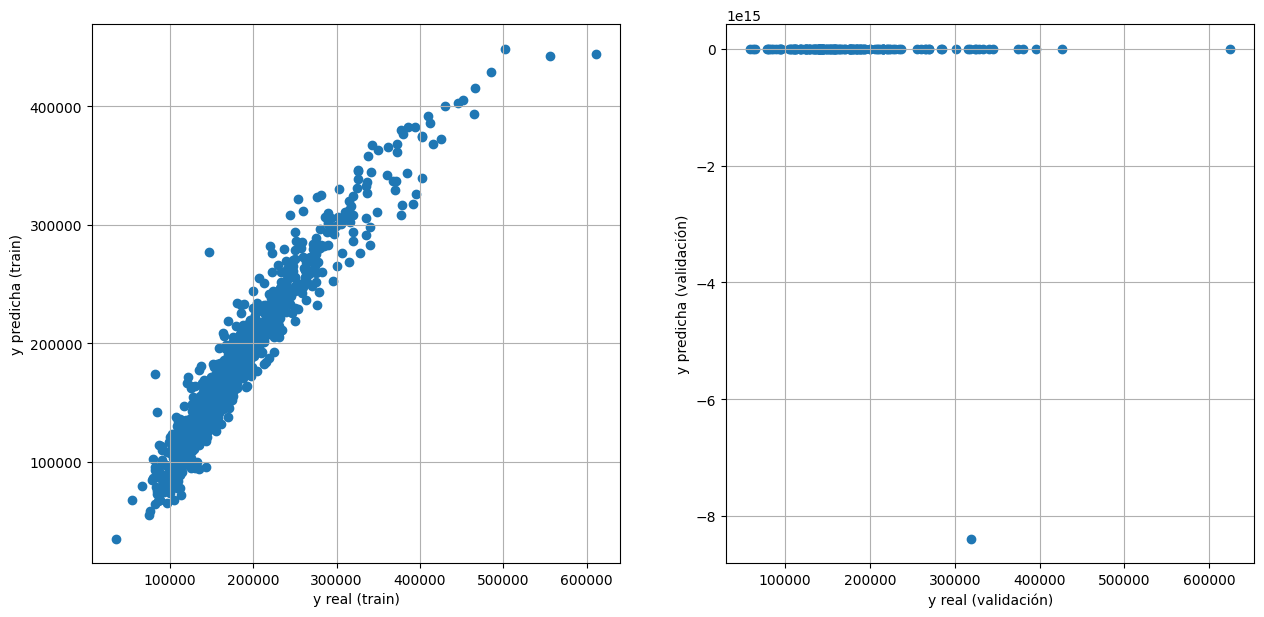

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(y_train, y_pred_train)
ax[0].set_xlabel('y real (train)')
ax[0].set_ylabel('y predicha (train)')
ax[0].grid()

ax[1].scatter(y_val, y_pred_val)
ax[1].set_xlabel('y real (validación)')
ax[1].set_ylabel('y predicha (validación)')
ax[1].grid()
plt.show()

Como vemos existe mínimo una instancia que predice un valor desorbitado que no se corresponde con el valor real. Esta instancia está afectando mucho a las métricas, vamos a ver qué instancia es y qué valores tiene. 

In [53]:
# Vamos a identificar la instancia del conjunto de validación con mayor error
y_pred_val = pd.Series(y_pred_val, index=y_val.index)
y_error = y_val - y_pred_val
y_error = y_error.abs()
y_error = y_error.sort_values(ascending=False)
print("La instancia con mayor error es la ", y_error.index[0], " con un error de ", y_error[y_error.index[0]])

# Eliminamos esa instancia de los conjuntos y_val e y_pred_val
y_val_fixed = y_val.drop(y_error.index[0])
y_pred_val_fixed = y_pred_val.drop(y_error.index[0])

La instancia con mayor error es la  595  con un error de  8388334858857991.0


In [55]:
# Mostramos las métricas de rendimiento para el conjunto de validación sin la instancia con mayor error
mae = mean_absolute_error(y_val_fixed, y_pred_val_fixed)
mse = mean_squared_error(y_val_fixed, y_pred_val_fixed)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_fixed, y_pred_val_fixed)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)

MAE:  16136.894287446774
MSE:  529989010.2883919
RMSE:  23021.490183921454
R2:  0.9126319129310492


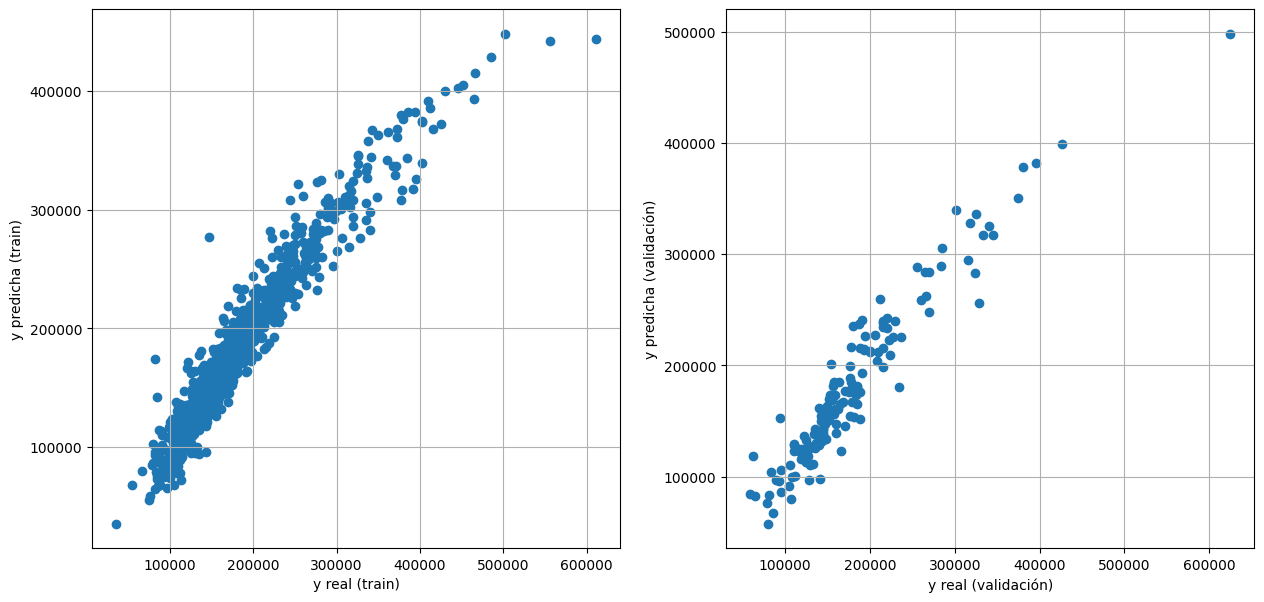

In [54]:
# Mostramos la misma gráfica que antes pero sin la instancia con mayor error
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(y_train, y_pred_train)
ax[0].set_xlabel('y real (train)')
ax[0].set_ylabel('y predicha (train)')
ax[0].grid()

ax[1].scatter(y_val_fixed, y_pred_val_fixed)
ax[1].set_xlabel('y real (validación)')
ax[1].set_ylabel('y predicha (validación)')
ax[1].grid()
plt.show()

Como vemos, las métricas pasan a obtener un valor mucho mejor, tanto el mae como el mse bajan considerablemente, y el R2 sube, tomando el valor de 0.91, un valor bastante aceptable y similar a las métricas obtenidas sobre el conjunto de entrenamiento. 

Esto nos indica que el modelo puede generalizar bien, pero hay alguna instancia que no es capaz de predecir, bien porque sea algún outlier que no hemos identificado, o bien porque el modelo no es capaz de generalizar bien en esa zona del espacio de características.

Para tratar de explicar este resultado, vamos a ver los pesos del modelo de regresión.

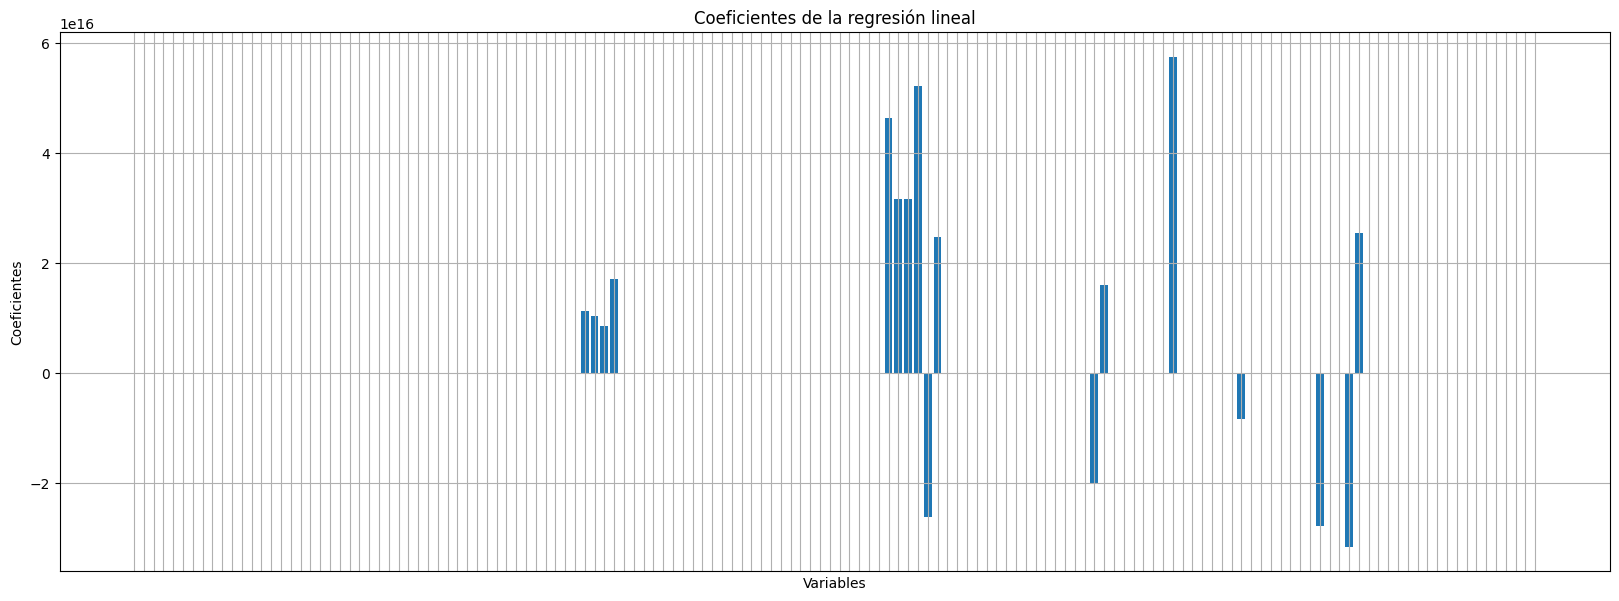

In [60]:
# graficamos los coeficientes
plt.figure(figsize=(20, 7))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.bar(X_train.columns, reg.coef_)
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.title('Coeficientes de la regresión lineal')
plt.grid()
plt.show()


En la gráfica anterior, se puede observar el motivo del sobreajuste sobre el conjunto de entrenamiento. Esto es provocado por el incremento no controlado de los pesos que se calculan en el aprendizaje, existe una desproporción en la cuantificación de estos y al multiplicar a los valores del conjunto de validación puede dar lugar a predicciones desmesuradas. Por ello, vimos necesario aplicar técnicas de regularización que nos permitieran decrementar el valor de estos coeficientes. Simplemente para confirmar nuestras ideas y descartar que las malas predicciones vienen dadas por outliers no detectados en el preprocesado de los datos. La regularización escogida es la denominada **Ridge**, pero antes de probarla, vamos a dar un rendimiento final del modelo básico de regresión lineal usando validación cruzada.

Mencionar que el modelo básico de regresión lineal, no tiene hiperparámetros relevantes que ajustar, por lo que es no es necesario realizar una búsqueda de hiperparámetros, ya que al fin y al cabo, encontrará el hiperplano que reduzca el error cuadrático medio con los datos de entrenamiento, y el resultado final será el mismo para los mismos datos.

In [69]:
# Aplicamos validación cruzada en el conjunto de entrenamiento más validación
lr = LinearRegression()
mse, mae, r2 = cross_validation(lr, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), n_splits=10)

# Mostramos las métricas de rendimiento
print("Validación cruzada:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print("R2: ", r2)

Validación cruzada:
MAE:  5840817250512647.0
MSE:  1.627448799799616e+34
RMSE:  1.2757150151188219e+17
R2:  0.4457572334291287


Como vemos, los resultados no son muy buenos, tal y como esperábamos. Hemos empleado una partición de k = 10 para la validación cruzada, y obtenemos unas métricas no muy buenas. Esto es debido, a que el modelo no es capaz de ajustarse de forma correcta a instancias más "límites" que van cayendo de forma esporádica en el conjunto de validación tomado, haciendo que haya particiones para las que los errores sean muy grandes, y estropee la media final.

## Ridge en modelo de Regresión Lineal

In [63]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred_val = ridge.predict(X_val)

# Calculamos las métricas de rendimiento
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)

# Mostramos las métricas de rendimiento
print("--CONJUNTO DE VALIDACION--")
print(" - MAE: ", mae)
print(" - MSE: ", mse)
print(" - RMSE: ", rmse)
print(" - R2: ", r2,"\n")

# Metricas sobre el conjunto de entrenamiento
y_pred_train = ridge.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

# Mostramos las métricas de rendimiento
print("--CONJUNTO DE ENTRENAMIENTO--")
print(" - MAE: ", mae)
print(" - MSE: ", mse)
print(" - RMSE: ", rmse)
print(" - R2: ", r2)

--CONJUNTO DE VALIDACION--
 - MAE:  16294.957151009961
 - MSE:  537482130.1662477
 - RMSE:  23183.660844789974
 - R2:  0.912653506904737 

--CONJUNTO DE ENTRENAMIENTO--
 - MAE:  14147.797811541282
 - MSE:  406329212.8373244
 - RMSE:  20157.609303618432
 - R2:  0.9218272376660919


Mostramos a continuación los valores de los pesos para verificar que nuestras hipótesis eran ciertas. 

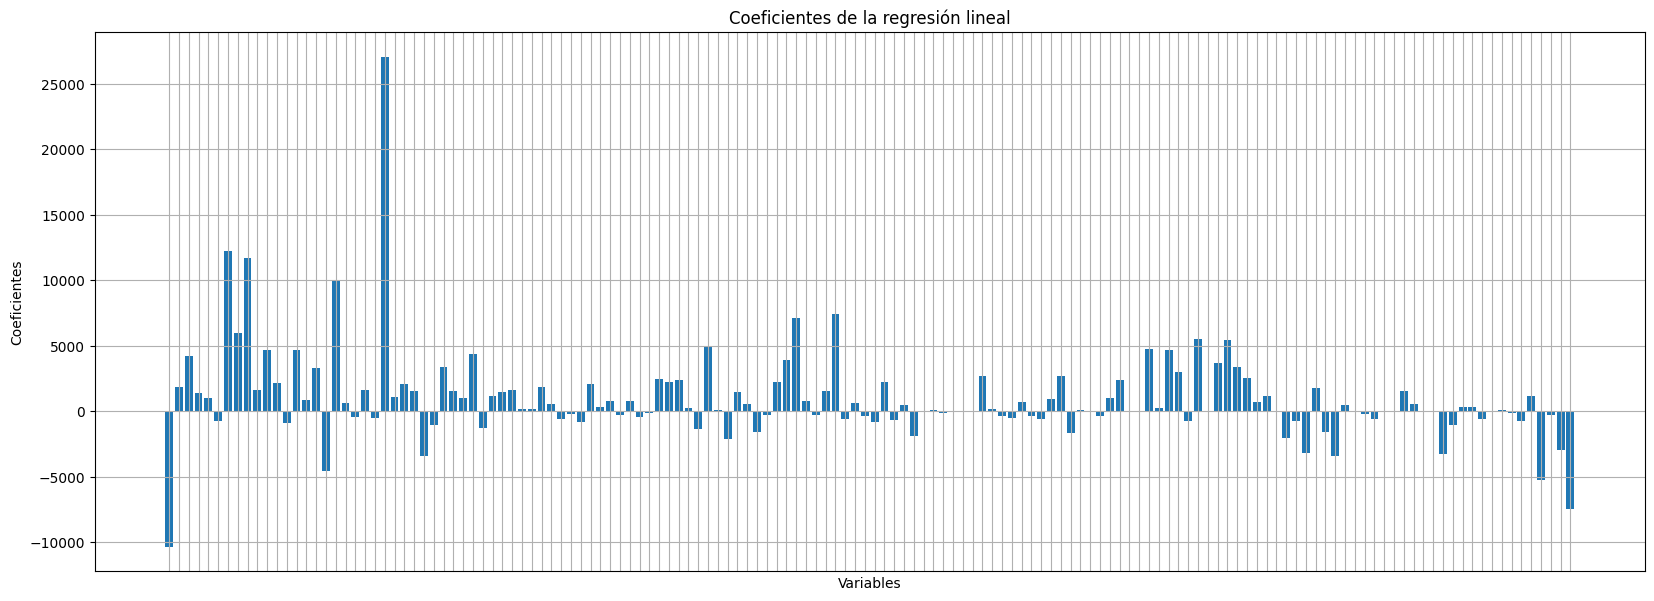

In [64]:
# graficamos los coeficientes
plt.figure(figsize=(20, 7))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.bar(X_train.columns, ridge.coef_)
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.title('Coeficientes de la regresión lineal')
plt.grid()
plt.show()

Como vemos, los pesos de los atributos son mucho más pequeños que en la regresión lineal, lo que indica que el modelo está correctamente regularizado. Se aprecia, como se consiguen unas métricas mucho mejores en el conjunto de validación, y por tanto, el modelo regularizado generaliza mejor.

Sin embargo, esta ha sido una primera aproximación, vamos a escoger el mejor hiperparámetro alpha para el conjunto de validación, y posteriormente, con el mejor modelo vamos a realizar validación cruzada para obtener una medida robusta del rendimiento del modelo.

In [70]:
# Aplicamos validación cruzada en el conjunto de entrenamiento más validación
ridge = Ridge(alpha=0.1)
mse, mae, r2 = cross_validation(ridge, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), n_splits=10)

# Mostramos las métricas de rendimiento
print("Validación cruzada:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print("R2: ", r2)

Validación cruzada:
MAE:  16780.57123741488
MSE:  565618447.4344049
RMSE:  23782.73422957093
R2:  0.8855713283791914


## Random Forest



En primera instancia vemos cómo funcionaría el modelo con parámetros por defecto con nuestro conjunto de datos

In [ ]:
## Cargamos el modelo Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo, entrenamos con el conjunto de entrenamiento
# y validamos con el conjunto de validación
rfreg = RandomForestRegressor(n_estimators=100, random_state=1)
rfreg.fit(X_train, y_train)

# Predecimos con el conjunto de entrenamiento
y_pred = rfreg.predict(X_train)

# Calculamos las métricas de rendimiento con el conjunto de entrenamiento
mae = mean_absolute_error(y_train.to_numpy(), y_pred)
mse = mean_squared_error(y_train.to_numpy(), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train.to_numpy(), y_pred)

# Mostramos las métricas de rendimiento
print("Métricas del modelo por defecto y prediciendo con el conjunto de entrenamiento:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2,"\n\n")


# Predecimos con el conjunto de validación
y_pred = rfreg.predict(X_val)

# Calculamos las métricas de rendimiento con el conjunto de validación
mae = mean_absolute_error(y_val.to_numpy(), y_pred)
mse = mean_squared_error(y_val.to_numpy(), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val.to_numpy(), y_pred)

# Mostramos las métricas de rendimiento
print("Métricas del modelo por defecto y prediciendo con el conjunto de validación:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)


Métricas del modelo por defecto y prediciendo con el conjunto de entrenamiento:
MAE:  5050.886762452106
MSE:  51355074.65692815
RMSE:  7166.245506325342
R2:  0.9843663015049857 


Métricas del modelo por defecto y prediciendo con el conjunto de validación:
MAE:  14670.940674157304
MSE:  463006317.770528
RMSE:  21517.58159669734
R2:  0.7627398112514172


Tras este primer acercamiento a los modelos ensemble, veremos el rendimiento de este modelo aplicando un ajuste de hiperparámetros con el conjunto de validación para poder quedarnos con un mejor modelo. Los hiperparámetros que hemos elegido ajustar son los siguientes:


- *n_estimators*: Número de árboles a emplear en el modelo ensemble.

- *criterion*: Función que medirá la calidad de la división. Cuyos valores son:
    - Error cuadrático 
    - Error absoluto
    - Error cuadrático medio con la mejora de Friedman
    - Reducción de Poisson <p>
- *max_depth*: Máxima profundida que podrá obtener cada árbol.

- *max_leaf_nodes*: Máximo número de Hojas. Su valor *None* se define como número ilimitado de hojas.

In [ ]:
# Hacemos la función que nos permitirá ajustar los hiperparámetros del modelo regresor de Random Forest
def rfregressor_grid_search(X_train, y_train, X_val, y_val, param_grid, n_splits=3):
    # Creamos el modelo
    rfreg = RandomForestRegressor(random_state=1)
    # Aplicamos validación cruzada
    grid_search = GridSearchCV(estimator=rfreg, param_grid=param_grid, cv=n_splits, n_jobs=-1, verbose=2)
    # Entrenamos el modelo
    grid_search.fit(X_train, y_train)
    # Obtenemos el mejor modelo
    best_model = grid_search.best_estimator_
    # Predecimos con el conjunto de validación
    y_pred = best_model.predict(X_val)
    # Calculamos las métricas de rendimiento con el conjunto de validación
    mae = mean_absolute_error(y_val.to_numpy(), y_pred)
    mse = mean_squared_error(y_val.to_numpy(), y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val.to_numpy(), y_pred)
    # Mostramos las métricas de rendimiento
    print("Métricas del modelo con los mejores hiperparámetros y prediciendo con el conjunto de validación:")
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R2: ", r2)
    return best_model

Finalmente, aplicaremos validación cruzada a ese último modelo elegido con los mejores hiperparámetros para verificar que estos parámetros realmente son buenos:

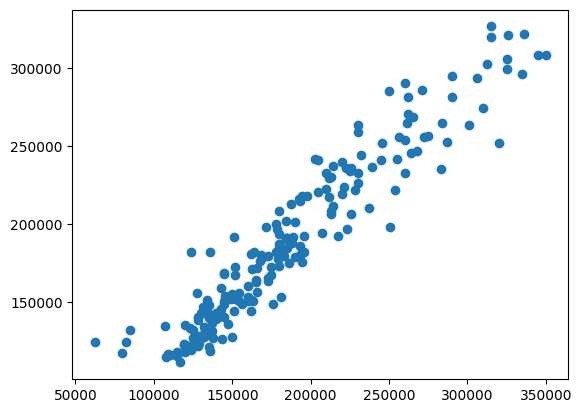

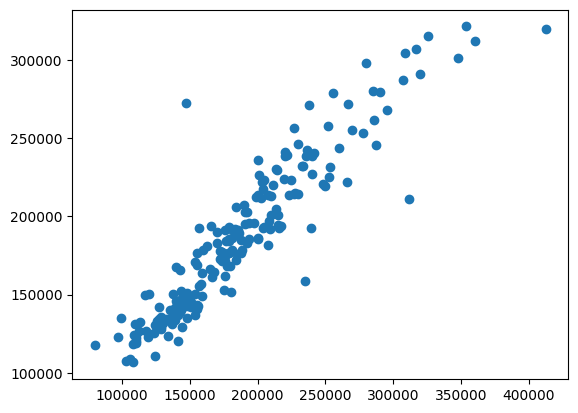

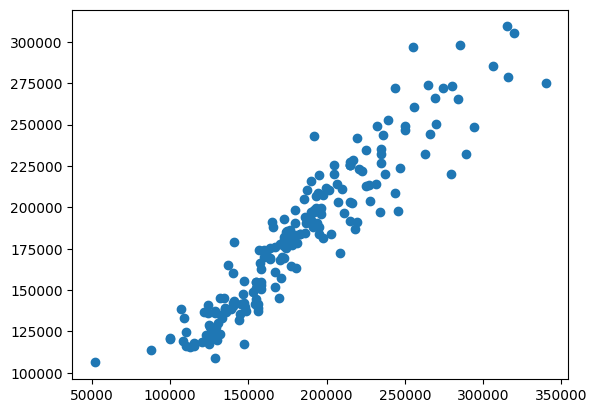

Validación cruzada:
MAE:  13297.485144644064
MSE:  365358626.1024688
RMSE:  19114.356544295933
R2:  0.8514240820354662


In [ ]:
# Aplicamos validación cruzada en el conjunto de entrenamiento más validación
mse, mae, r2 = cross_validation(RandomForestRegressor, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), n_splits=3)

# Mostramos las métricas de rendimiento
print("Validación cruzada:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print("R2: ", r2)


## Gradient Boosting

In [ ]:
# # Entrenamos gradient boosting con los datos de entrenamiento
from sklearn.ensemble import GradientBoostingRegressor

# Entrenamos el modelo con los datos de entrenamiento
gbr = GradientBoostingRegressor(random_state=41)
gbr.fit(X_train, y_train)

# Predecimos los valores de la variable objetivo para los datos de entrenamiento
y_train_pred = gbr.predict(X_train)

# Predecimos los valores de la variable objetivo para los datos de validación
y_val_pred = gbr.predict(X_val)

# Evaluamos el rendimiento del modelo con los datos de entrenamiento
print("Rendimiento del modelo con los datos de entrenamiento:")
print("MAE: ", mean_absolute_error(y_train, y_train_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R2: ", r2_score(y_train, y_train_pred), "\n\n")

# Evaluamos el rendimiento del modelo con los datos de validación
print("Rendimiento del modelo con los datos de validación:")
print("MAE: ", mean_absolute_error(y_val, y_val_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("R2: ", r2_score(y_val, y_val_pred))


Rendimiento del modelo con los datos de entrenamiento:
MAE:  6557.963148359388
RMSE:  8255.96730919662
R2:  0.9792501817786496
Rendimiento del modelo con los datos de validación:
MAE:  12349.742212418907
RMSE:  18955.359408463602
R2:  0.8158795611687164


Los hiperparámetros que hemos elegido ajustar son los siguientes:

- *loss*: Función de pérdida a optimizar. Valores:
    - error cuadrático para regresión
    - error absoluto
    - huber: combinación de las dos anteriores<p>


- *learning rate*: factor de aprendizaje que hará que se aprenda más rápido o más lento en nuestro modelo.

- *n_estimators*: Número de árboles a emplear en el modelo ensemble.

- *criterion*: Función que medirá la calidad de la división. Cuyos valores son:
    - Error cuadrático 
    - Error cuadrático medio con la mejora de friedman<p>

- *max_depth*: Máxima profundida que podrá obtener cada árbol.

- *max_leaf_nodes*: Máximo número de Hojas. Su valor *None* se define como número ilimitado de hojas.

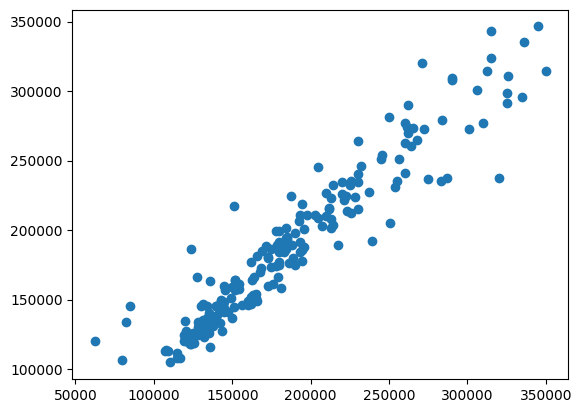

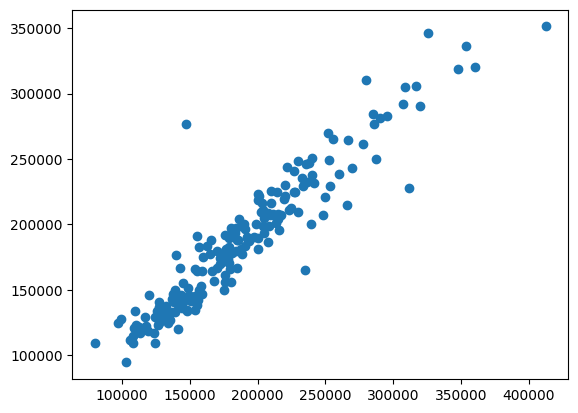

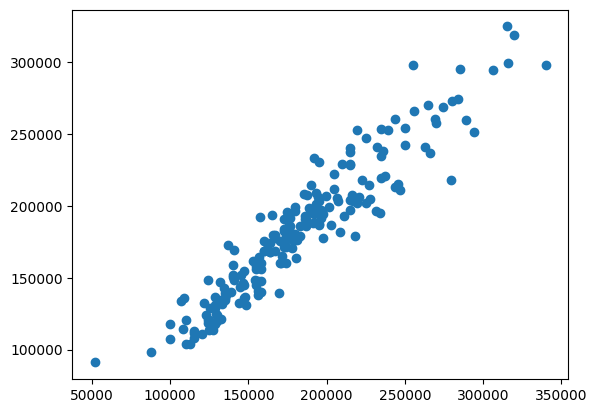

In [ ]:
mse, mae, r2 = cross_validation(GradientBoostingRegressor, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), n_splits=3)

In [ ]:
# Mostramos las métricas de rendimiento
print("Validación cruzada:")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print("R2: ", r2)

Validación cruzada:
MAE:  12519.835812844001
MSE:  325802363.1590171
RMSE:  18049.996209390658
R2:  0.8797627692878781


# Modelo Final

Escogemos ... ya que es ...

COSAS QUE HAY QUE HACER:

**Preprocesado de datos** DONE
- Eliminar columnas con muchos valores perdidos
- One-hot encoding / Label encoding (categorical variables)
- Normalizar datos: StandardScaler, MinMaxScaler, RobustScaler 
- Eliminar outliers: IQR, Z-score, etc.  (?)
- Discretizado de variables continuas (?): Binning, etc.


**Ingeneering features** DONE
- Reducción de dimensionalidad: *PCA*, LDA, etc.
- Selección de variables - Filter Methods: Correlation, Chi2, ANOVA, etc.
- Multicolinealidad: VIF, etc. 
- Crear nuevas variables.

**Posibles Modelos**
- Regresión lineal
- Regresión polinómica
- Regresión Ridge
- Regresión Lasso
- Regresión ElasticNet
- SVR
- Random Forest
- **Gradient Boosting**
- XGBoost
- LightGBM
- CatBoost

**Evaluación de modelos**
- MSE
- k-fold cross validation
- Recall, Precision, F1-score, etc. (?)